<a href="https://colab.research.google.com/github/Devininthelab/Toy-Repo/blob/main/GAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
from torch.utils.tensorboard import SummaryWriter

# Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
BATCH_SIZE = 128
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 9720831.53it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177427.99it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3203794.35it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2090451.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

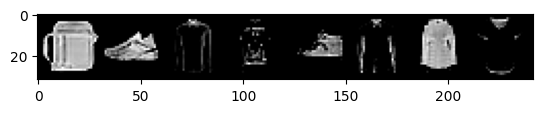

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*1
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

In [ ]:
print(len(trainloader))
print(len(testloader))

469
79


In [ ]:
for images, labels in trainloader:
    print(images.shape)
    break

torch.Size([128, 1, 28, 28])


# Model

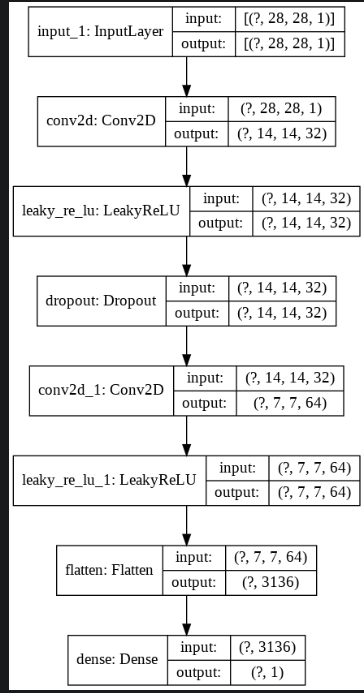

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding="same", stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.lrelu = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same", stride=1)
        self.linear = nn.Linear(in_features=7*7*64, out_features=1)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.lrelu(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return nn.Sigmoid()(x)


In [ ]:
inputs = torch.randn(size=(3, 1, 28, 28))
model = Discriminator(in_channels=1)
print(model(inputs))

tensor([[0.5439],
        [0.5551],
        [0.5320]], grad_fn=<SigmoidBackward0>)


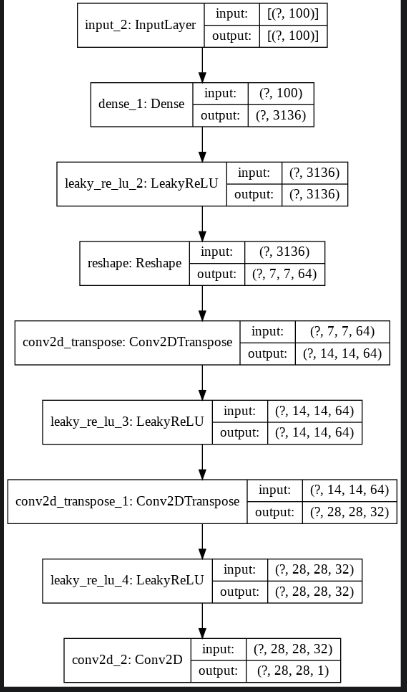

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_size=100):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=3136),
            nn.LeakyReLU(0.1),
        )
        self.trans_conv2d1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=6, padding=2, stride=2)
        self.tanh = nn.Tanh()
        self.trans_conv2d2 =nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, padding=2, stride=2)
        self.lrelu = nn.LeakyReLU()
        self.conv2d = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding='same')

    def forward(self, x):
        x = self.gen(x) # (-1, 3136)
        x = x.view(-1, 64, 7, 7)
        x = self.trans_conv2d1(x)
        x = self.tanh(x)
        x = self.trans_conv2d2(x)
        x = self.lrelu(x)
        x = self.conv2d(x)
        return x


In [ ]:
class GAN(nn.Module):
    def __init__(self, in_channels, noise_size):
        self.gen = Generator(noise_size=noise_size)
        self.disc = Discriminator(in_channels=in_channels)

#HyperParams

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
noise_dim = 64
image_dim = 1
batch_size = 32
num_epochs = 50


disc = Discriminator(1).to(device)
gen = Generator(noise_size=noise_dim).to(device)
fixed_noise = torch.randn((batch_size, noise_dim)).to(device)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"runs/GAN_FashionMNIST/fake") #only output fake images
writer_real = SummaryWriter(f"runs/GAN_FashionMNIST/real")
step = 0

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(trainloader):
        real = real.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max(log(D(real))) + log(1-D(G(z)))
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1) # flatten everything
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()


        ### train generator min log(1-D(G(z))) <-> max log D(G(z))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize = True)
                img_grid_real = torchvision.utils.make_grid(data, normalize = True)

                writer_fake.add_image(
                    "FMnist Fake images", img_grid_fake, global_step=step
                )

                writer_real.add_image(
                    "FMnist Real images", img_grid_real, global_step=step
                )

                step += 1

Epoch [0/50] Loss D: 0.7565, Loss G: 0.7219
Epoch [1/50] Loss D: 0.3607, Loss G: 0.6994


KeyboardInterrupt: 